# Simple User Manual
The [nn_framework.py](nn_framework.py) file contains all the trajectory inference methods in this paper.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import nn_framework # computational framework
import load # load data

There are several data sets in this repository.
- moon: Human Embryonic Stem Cells Dataset
- wot: Mouse Embryonic Fibroblasts Dataset
- root: *Arabidopsis thaliana* Stem Cells Dataset

In the following example, we will use the data "circle" for simplicity.

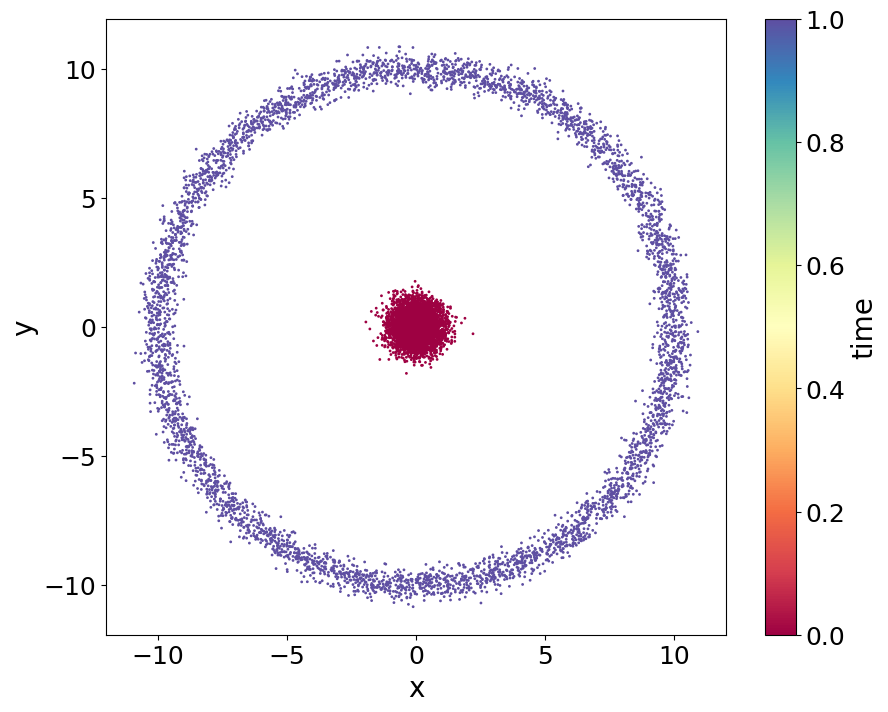

In [2]:
data, T = load.load('circle', frac=1) # frac=1 means all data and T is the maximum number of time points - 1.
load.sde_plot(data) # plot the data

Now we can set the parameters for the model.

In [3]:
N = data.shape[0] # number of data points

nn_framework.torch.manual_seed(12345) # set random seed for reproducibility
rng = np.random.default_rng(12345) # set random seed for reproducibility

scaler = StandardScaler()

data_scaled = scaler.fit_transform(data[['x', 'y']]) # scale data
data[['x', 'y']] = data_scaled # replace data with scaled data

param_list = {
                # regularizer
                'r_v': 0.1,
                'r_ent': 1, # takes values from [1, 5, 10]
                'r_kl': 1, # takes values from [1, 5, 10]
                'r_lock': 1, # takes values from [1, 5, 10]
                'k': 5,
                'lock_dist': 0.01, # 0.01
                # model setting
                'nt_grid': 30, # number of time points in the grid
                'n_sample': 100, # number of samples to estimate the expectation
                # simulation setting
                'nt': 30,
                'n_test': 100,
                's1': 0.01, # takes values from [0.01, 0.05, 0.1]
                's2': 0.01,
                'h': 1, # 10
                # optimization
                'lr': 0.001,
                'n_iter': 500,
             }

param_list['n_layers'] = 3 # number of layers in the neural network

x0 = data[data.time == 0][['x', 'y']].sample(500, replace=True).to_numpy() # initial condition
t_check = data.time.unique() # time points to check
t_check.sort() # sort time points
t_check = t_check[t_check > 0] # remove time 0

Now we can run a model on the data. In the [nn_framework.py](nn_framework.py) file, there are multiple supported methods.
- `train_alg_mfc_soft`: TrajectoryNet
- `train_alg_mfc_fbsde`: FBSDE

Note that the FBSDE method takes signifantly more computational resources. We recommmend the users to use a GPU-adapted environment for these computations. 

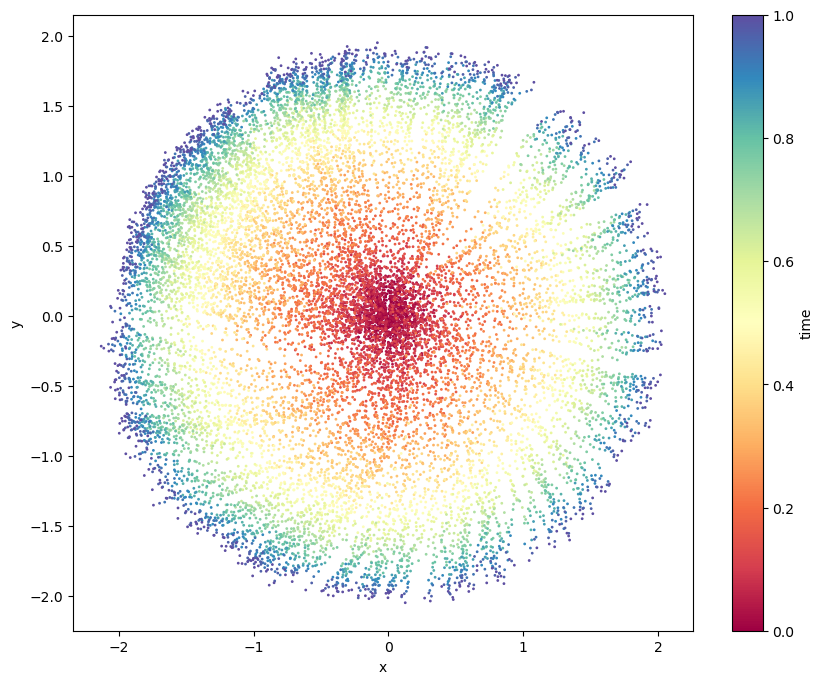

In [4]:
res = nn_framework.train_alg_mfc_soft(data, T=T, track=False, **param_list) # train the model
# nn_framework.torch.save(res['model'], model_name) save the model if needed
res_sim = nn_framework.sim_path_soft(res['model'], x0, T=T, t_check=t_check, plot=True, use_gpu=False, **param_list) # simulate the model